In [2]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, precision_score, precision_recall_curve, auc, roc_auc_score, roc_curve, recall_score, accuracy_score, classification_report
from imblearn.over_sampling import SMOTE
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.model_selection import StratifiedKFold

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle
import re
import datetime as dt

from pybaseball import *

from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import psycopg2
import pandas.io.sql as psql
from sqlalchemy import create_engine

from imblearn.over_sampling import RandomOverSampler

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 200)
plt.style.use("ggplot")

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [4]:
def makeOverSamplesSMOTE(X,y):
    #input DataFrame
    #X →Independent Variable in DataFrame\
    #y →dependent Variable in Pandas DataFrame format
    from imblearn.over_sampling import SMOTE
    sm = SMOTE()
    X, y = sm.fit_sample(X, y)
    return X,y

In [5]:
def makeOverSamplesADASYN(X,y):
    #input DataFrame
    #X →Independent Variable in DataFrame\
    #y →dependent Variable in Pandas DataFrame format
    from imblearn.over_sampling import ADASYN 
    sm = ADASYN()
    X, y = sm.fit_sample(X, y)
    return(X,y)

In [4]:
drop = ['#days', '2b', '3b', 'ab', 'cs', 'date', 'days', 'days_preceeding', 'enddate', 'era', 'first_x',
        'first_y', 'g', 'gdp', 'gs', 'ibb', 'injury', 'key_bbref_x', 'key_bbref_y', 'key_fangraphs_x',
        'key_fangraphs_y', 'key_mlbam', 'key_retro_x', 'key_retro_y', 'l', 'last_x', 'last_y', 'ld',
        'lev', 'list', 'mlb_played_first_y', 'mlb_played_last_x', 'mlb_played_last_y', 'moneyearned',
        'name_first_x', 'name_first_y', 'name_last_x', 'name_last_y', 'name_x', 'name_y', 'po', 'posititon',
        'pu', 'sb', 'sf', 'so/w', 'startdate', 'stl', 'sts', 'sv', 'team', 'tm', 'year']

In [6]:
# X = total
X = total.drop(columns=drop)
# X = X.replace([np.inf, -np.inf], np.nan)
# X = X[X['fb_count'].notnull() | X['os_count'].notnull()]
# X['fb_count'] = X['fb_count']/X['pit']
# X['os_count'] = X['os_count']/X['pit']

# X['hist_fb_count'] = X['hist_fb_count'] / (X['hist_fb_count'] + X['hist_os_count'])
# X['hist_os_count'] = 1 - X['hist_fb_count']


X['fb_count'] = X['fb_count'].fillna(X['hist_fb_count'])
X['p_throws_x'] = X['p_throws_x'].fillna(X['p_throws_y'])
X['fb_release_speed'] = X['fb_release_speed'].fillna(X['hist_fb_release_speed'])
X['fb_percieved_speed'] = X['fb_percieved_speed'].fillna(X['hist_fb_percieved_speed'])
X['fb_spin_rate'] = X['fb_spin_rate'].fillna(X['hist_fb_spin_rate'])
X['fb_avg_x'] = X['fb_avg_x'].fillna(X['hist_fb_avg_x'])
X['fb_avg_z'] = X['fb_avg_z'].fillna(X['hist_fb_avg_z'])
X['fb_avg_extension'] = X['fb_avg_extension'].fillna(X['hist_fb_avg_extension'])
X['fb_x_movement'] = X['fb_x_movement'].fillna(X['hist_fb_x_movement'])
X['fb_z_movement'] = X['fb_z_movement'].fillna(X['hist_fb_z_movement'])
X['os_count'] = X['os_count'].fillna(X['hist_os_count'])
X['os_release_speed'] = X['os_release_speed'].fillna(X['hist_os_release_speed'])
X['os_percieved_speed'] = X['os_percieved_speed'].fillna(X['hist_os_percieved_speed'])
X['os_spin_rate'] = X['os_spin_rate'].fillna(X['hist_os_spin_rate'])
X['os_avg_x'] = X['os_avg_x'].fillna(X['hist_os_avg_x'])
X['os_avg_z'] = X['os_avg_z'].fillna(X['hist_os_avg_z'])
X['os_avg_extension'] = X['os_avg_extension'].fillna(X['hist_os_avg_extension'])
X['os_x_movement'] = X['os_x_movement'].fillna(X['hist_os_x_movement'])
X['os_z_movement'] = X['os_z_movement'].fillna(X['hist_os_z_movement'])
X = X.drop(columns='p_throws_y')
X = X.fillna(0)
X['fb_count'] = X['fb_count']/X['pit']
X['os_count'] = X['os_count']/X['pit']
X['hist_fb_count'] = X['hist_fb_count'] / (X['hist_fb_count'] + X['hist_os_count'])
X['hist_os_count'] = 1 - X['hist_fb_count']
X['fb_count'].mask(X['fb_count'] > 1, other=X['hist_fb_count'], inplace=True)
X['os_count'].mask(X['os_count'] > 1, other=X['hist_os_count'], inplace=True)

In [7]:
X.head()

,age,appearance_yr,babip,bb,bf,days_rest,er,gb/fb,h,hbp,hr,injured?,ip,mlb_played_first_x,pit,r,so,so9,str,w,whip,fb_count,p_throws_x,fb_release_speed,fb_percieved_speed,fb_spin_rate,fb_avg_x,fb_avg_z,fb_avg_extension,fb_x_movement,fb_z_movement,os_count,os_release_speed,os_percieved_speed,os_spin_rate,os_avg_x,os_avg_z,os_avg_extension,os_x_movement,os_z_movement,hist_fb_count,hist_fb_release_speed,hist_fb_percieved_speed,hist_fb_spin_rate,hist_fb_avg_x,hist_fb_avg_z,hist_fb_avg_extension,hist_fb_x_movement,hist_fb_z_movement,hist_os_count,hist_os_release_speed,hist_os_percieved_speed,hist_os_spin_rate,hist_os_avg_x,hist_os_avg_z,hist_os_avg_extension,hist_os_x_movement,hist_os_z_movement
0,42.0,1,0.154,1.0,23.0,182.0,1.0,0.64,3.0,0.0,1.0,0.0,6.0,1997.0,86.0,1.0,8.0,12.0,0.69,1.0,0.667,0.883721,R,89.784211,88.202553,2280.710526,-1.481718,5.916537,5.605737,-1.026215,1.276848,0.116279,83.540000,81.596556,2469.444444,-1.733989,5.992122,5.262667,0.046602,0.628567,0.840393,88.212583,86.265537,2148.40505,-1.331322,5.707565,5.262154,-1.20338,0.998063,0.159607,81.785151,79.950319,1980.118786,-1.467546,5.665911,5.12686,-0.49641,0.636257
1,42.0,2,0.238,0.0,27.0,6.0,3.0,0.33,6.0,0.0,1.0,0.0,7.0,1997.0,77.0,3.0,5.0,6.4,0.78,1.0,0.857,0.922078,R,88.569014,86.327366,2133.971831,-1.161156,5.956703,5.049437,-0.843298,1.237249,0.077922,82.000000,80.086500,1761.833333,-1.357450,6.000083,4.996000,-0.546108,0.733678,0.840393,88.212583,86.265537,2148.40505,-1.331322,5.707565,5.262154,-1.20338,0.998063,0.159607,81.785151,79.950319,1980.118786,-1.467546,5.665911,5.12686,-0.49641,0.636257
2,42.0,3,0.250,0.0,26.0,5.0,1.0,0.43,6.0,0.0,1.0,0.0,7.0,1997.0,91.0,1.0,5.0,6.4,0.73,1.0,0.857,0.835165,R,89.246053,87.101987,2193.346667,-1.295146,6.124792,5.372947,-1.087467,1.038179,0.164835,82.940000,80.848267,1817.461538,-1.520147,6.105167,5.204200,-0.449991,0.594358,0.840393,88.212583,86.265537,2148.40505,-1.331322,5.707565,5.262154,-1.20338,0.998063,0.159607,81.785151,79.950319,1980.118786,-1.467546,5.665911,5.12686,-0.49641,0.636257
3,42.0,4,0.368,0.0,24.0,6.0,3.0,0.22,7.0,0.0,0.0,0.0,6.0,1997.0,88.0,3.0,5.0,7.5,0.66,1.0,1.167,0.909091,R,89.025000,86.779882,2196.473684,-1.227378,6.096868,5.243171,-1.292720,1.116850,0.125000,81.936364,79.716000,2036.363636,-1.438264,6.180809,5.089818,-0.711843,0.584264,0.840393,88.212583,86.265537,2148.40505,-1.331322,5.707565,5.262154,-1.20338,0.998063,0.159607,81.785151,79.950319,1980.118786,-1.467546,5.665911,5.12686,-0.49641,0.636257
4,42.0,5,0.333,0.0,29.0,6.0,4.0,0.48,9.0,0.0,1.0,0.0,6.2,1997.0,91.0,4.0,2.0,2.7,0.70,0.0,1.350,0.791209,R,88.462500,86.099380,2192.563380,-0.902362,6.524101,5.158310,-1.210262,1.227521,0.186813,82.476471,79.931938,2331.312500,-1.208682,6.446600,4.900688,-0.017521,0.677131,0.840393,88.212583,86.265537,2148.40505,-1.331322,5.707565,5.262154,-1.20338,0.998063,0.159607,81.785151,79.950319,1980.118786,-1.467546,5.665911,5.12686,-0.49641,0.636257


In [8]:
X[X['fb_count'].isnull()]
# X['p_throws_x'] = X['p_throws_x'].fillna(X['p_throws_y'])

,age,appearance_yr,babip,bb,bf,days_rest,er,gb/fb,h,hbp,hr,injured?,ip,mlb_played_first_x,pit,r,so,so9,str,w,whip,fb_count,p_throws_x,fb_release_speed,fb_percieved_speed,fb_spin_rate,fb_avg_x,fb_avg_z,fb_avg_extension,fb_x_movement,fb_z_movement,os_count,os_release_speed,os_percieved_speed,os_spin_rate,os_avg_x,os_avg_z,os_avg_extension,os_x_movement,os_z_movement,hist_fb_count,hist_fb_release_speed,hist_fb_percieved_speed,hist_fb_spin_rate,hist_fb_avg_x,hist_fb_avg_z,hist_fb_avg_extension,hist_fb_x_movement,hist_fb_z_movement,hist_os_count,hist_os_release_speed,hist_os_percieved_speed,hist_os_spin_rate,hist_os_avg_x,hist_os_avg_z,hist_os_avg_extension,hist_os_x_movement,hist_os_z_movement


In [9]:
X['delta_fb_release_speed'] = X['hist_fb_release_speed'] - X['fb_release_speed']
X['delta_fb_percieved_speed'] = X['hist_fb_percieved_speed'] - X['fb_percieved_speed']
X['delta_fb_spin_rate'] = X['hist_fb_spin_rate'] - X['fb_spin_rate']
X['delta_fb_avg_x'] = X['hist_fb_avg_x'] - X['fb_avg_x']
X['delta_fb_avg_z'] = X['hist_fb_avg_z'] - X['fb_avg_z']
X['delta_fb_avg_extension'] = X['hist_fb_avg_extension'] - X['fb_avg_extension']
X['delta_fb_x_movement'] = X['hist_fb_x_movement'] - X['fb_x_movement']
X['delta_fb_z_movement'] = X['hist_fb_z_movement'] - X['fb_z_movement']
X['delta_os_release_speed'] = X['hist_os_release_speed'] - X['os_release_speed']
X['delta_os_percieved_speed'] = X['hist_os_percieved_speed'] - X['os_percieved_speed']
X['delta_os_spin_rate'] = X['hist_os_spin_rate'] - X['os_spin_rate']
X['delta_os_avg_x'] = X['hist_os_avg_x'] - X['os_avg_x']
X['delta_os_avg_z'] = X['hist_os_avg_z'] - X['os_avg_z']
X['delta_os_avg_extension'] = X['hist_os_avg_extension'] - X['os_avg_extension']
X['delta_os_x_movement'] = X['hist_os_x_movement'] - X['os_x_movement']
X['delta_os_z_movement'] = X['hist_os_z_movement'] - X['os_z_movement']
X['delta_fb_count'] = X['hist_fb_count'] - X['fb_count']
X['delta_os_count'] = X['hist_os_count'] - X['os_count']

In [10]:
inj = X[X['injured?'] == 1]
inj[inj['fb_count'] == 0]

,age,appearance_yr,babip,bb,bf,days_rest,er,gb/fb,h,hbp,hr,injured?,ip,mlb_played_first_x,pit,r,so,so9,str,w,whip,fb_count,p_throws_x,fb_release_speed,fb_percieved_speed,fb_spin_rate,fb_avg_x,fb_avg_z,fb_avg_extension,fb_x_movement,fb_z_movement,os_count,os_release_speed,os_percieved_speed,os_spin_rate,os_avg_x,os_avg_z,os_avg_extension,os_x_movement,os_z_movement,hist_fb_count,hist_fb_release_speed,hist_fb_percieved_speed,hist_fb_spin_rate,hist_fb_avg_x,hist_fb_avg_z,hist_fb_avg_extension,hist_fb_x_movement,hist_fb_z_movement,hist_os_count,hist_os_release_speed,hist_os_percieved_speed,hist_os_spin_rate,hist_os_avg_x,hist_os_avg_z,hist_os_avg_extension,hist_os_x_movement,hist_os_z_movement,delta_fb_release_speed,delta_fb_percieved_speed,delta_fb_spin_rate,delta_fb_avg_x,delta_fb_avg_z,delta_fb_avg_extension,delta_fb_x_movement,delta_fb_z_movement,delta_os_release_speed,delta_os_percieved_speed,delta_os_spin_rate,delta_os_avg_x,delta_os_avg_z,delta_os_avg_extension,delta_os_x_movement,delta_os_z_movement,delta_fb_count,delta_os_count
22054,30.0,1,0.0,0.0,2.0,182.0,0.0,1.0,0.0,0.0,0.0,1.0,0.2,2011.0,10.0,0.0,1.0,13.5,0.5,0.0,0.0,0.0,R,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,86.71,85.6988,1944.3,-3.05894,6.11778,5.7948,-0.37024,1.1835,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,86.71,85.6988,1944.3,-3.05894,6.11778,5.7948,-0.37024,1.1835,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
dummies = pd.get_dummies(X['p_throws_x'])
dummies

,0,L,R
0,0,0,1
1,0,0,1
2,0,0,1
3,0,0,1
4,0,0,1
5,0,0,1
6,0,0,1
7,0,0,1
8,0,0,1
9,0,0,1


In [12]:
X = pd.concat([X, dummies], axis=1)

In [13]:
X['injured?'].sum()

876.0

In [14]:
# X = X[X['fb_count'] != 0]
# X = X[X['os_count'] != 0]
X[X['os_count'] > 1]

,age,appearance_yr,babip,bb,bf,days_rest,er,gb/fb,h,hbp,hr,injured?,ip,mlb_played_first_x,pit,r,so,so9,str,w,whip,fb_count,p_throws_x,fb_release_speed,fb_percieved_speed,fb_spin_rate,fb_avg_x,fb_avg_z,fb_avg_extension,fb_x_movement,fb_z_movement,os_count,os_release_speed,os_percieved_speed,os_spin_rate,os_avg_x,os_avg_z,os_avg_extension,os_x_movement,os_z_movement,hist_fb_count,hist_fb_release_speed,hist_fb_percieved_speed,hist_fb_spin_rate,hist_fb_avg_x,hist_fb_avg_z,hist_fb_avg_extension,hist_fb_x_movement,hist_fb_z_movement,hist_os_count,hist_os_release_speed,hist_os_percieved_speed,hist_os_spin_rate,hist_os_avg_x,hist_os_avg_z,hist_os_avg_extension,hist_os_x_movement,hist_os_z_movement,delta_fb_release_speed,delta_fb_percieved_speed,delta_fb_spin_rate,delta_fb_avg_x,delta_fb_avg_z,delta_fb_avg_extension,delta_fb_x_movement,delta_fb_z_movement,delta_os_release_speed,delta_os_percieved_speed,delta_os_spin_rate,delta_os_avg_x,delta_os_avg_z,delta_os_avg_extension,delta_os_x_movement,delta_os_z_movement,delta_fb_count,delta_os_count,0,L,R


In [15]:
X.describe()

,age,appearance_yr,babip,bb,bf,days_rest,er,gb/fb,h,hbp,hr,injured?,ip,mlb_played_first_x,pit,r,so,so9,str,w,whip,fb_count,fb_release_speed,fb_percieved_speed,fb_spin_rate,fb_avg_x,fb_avg_z,fb_avg_extension,fb_x_movement,fb_z_movement,os_count,os_release_speed,os_percieved_speed,os_spin_rate,os_avg_x,os_avg_z,os_avg_extension,os_x_movement,os_z_movement,hist_fb_count,hist_fb_release_speed,hist_fb_percieved_speed,hist_fb_spin_rate,hist_fb_avg_x,hist_fb_avg_z,hist_fb_avg_extension,hist_fb_x_movement,hist_fb_z_movement,hist_os_count,hist_os_release_speed,hist_os_percieved_speed,hist_os_spin_rate,hist_os_avg_x,hist_os_avg_z,hist_os_avg_extension,hist_os_x_movement,hist_os_z_movement,delta_fb_release_speed,delta_fb_percieved_speed,delta_fb_spin_rate,delta_fb_avg_x,delta_fb_avg_z,delta_fb_avg_extension,delta_fb_x_movement,delta_fb_z_movement,delta_os_release_speed,delta_os_percieved_speed,delta_os_spin_rate,delta_os_avg_x,delta_os_avg_z,delta_os_avg_extension,delta_os_x_movement,delta_os_z_movement,delta_fb_count,delta_os_count,0,L,R
count,81706.000000,81706.000000,81706.000000,81706.000000,81706.000000,81706.000000,81706.000000,81706.000000,81706.000000,81706.000000,81706.000000,81706.000000,81706.000000,81706.000000,81706.000000,81706.000000,81706.000000,81706.000000,81706.000000,81706.000000,81706.000000,81706.000000,81706.000000,81706.000000,81706.000000,81706.000000,81706.000000,81706.000000,81706.000000,81706.000000,81706.000000,81706.000000,81706.000000,81706.000000,81706.000000,81706.000000,81706.000000,81706.000000,81706.000000,81706.000000,81706.000000,81706.000000,81706.000000,81706.000000,81706.000000,81706.000000,81706.000000,81706.000000,81706.000000,81706.000000,81706.000000,81706.000000,81706.000000,81706.000000,81706.000000,81706.000000,81706.000000,81706.000000,81706.000000,81706.000000,81706.000000,81706.000000,81706.000000,81706.000000,81706.000000,81706.000000,81706.000000,81706.000000,81706.000000,81706.000000,81706.000000,81706.000000,81706.000000,81706.000000,81706.000000,81706.000000,81706.000000,81706.000000
mean,28.555235,22.576996,0.265655,0.742283,9.036729,11.047194,0.981935,0.434789,2.050694,0.084865,0.271706,0.010721,1.997540,2011.846095,35.040854,1.059433,1.929944,8.499512,0.647507,0.118902,1.473239,0.575483,93.024343,92.592361,2224.913436,-0.782639,5.887554,6.130092,-0.369826,1.228966,0.434868,83.871297,83.173467,2174.143720,-0.805829,5.873163,5.870576,0.031398,0.233650,0.569786,92.984235,92.556136,2224.204713,-0.784478,5.885664,6.135026,-0.370792,1.232952,0.430214,83.869388,83.178716,2173.686721,-0.806529,5.870055,5.875833,0.032703,0.241811,-0.040107,-0.036224,-0.708723,-0.001839,-0.001890,0.004934,-0.000966,0.003986,-0.001909,0.005249,-0.456999,-0.000700,-0.003108,0.005256,0.001305,0.008161,-0.005697,-0.004653,0.001640,0.276271,0.722089
std,3.702100,17.495504,0.268089,1.064313,8.795993,34.258006,1.572573,0.316659,2.442810,0.305019,0.591043,0.102988,2.151595,3.951111,33.770271,1.656483,2.239481,7.580094,0.117653,0.323675,1.835806,0.187031,3.873778,4.007074,179.525268,1.955694,0.595375,0.481679,0.862478,0.419544,0.185285,3.608054,3.822050,351.144541,2.007583,0.564938,0.461198,0.567541,0.470538,0.124702,3.732051,3.848131,163.088317,1.931836,0.571026,0.446726,0.837640,0.373813,0.124702,3.089913,3.249373,270.156644,1.984496,0.539092,0.411666,0.439655,0.356124,1.056579,1.143389,75.863242,0.305588,0.169307,0.181457,0.210735,0.194481,1.821179,1.970947,224.313477,0.307961,0.171629,0.209303,0.355799,0.303071,0.147961,0.140091,0.040464,0.447155,0.447972
min,19.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1995.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.304443,0.000000,0.000000,-3.363567,-1.180811,0.000000,0.000000,0.000000,0.000000,-16.834350,0.000000,0.000000,-2.427247,-1.832300,0.000000,0.000000,0.000000,0.000000,-4.521620,0.000000,0.000000,-1.597938,-0.822354,0.000000,0.000

In [16]:
ok = ['hist_fb_count',
 'hist_fb_release_speed',
 'hist_fb_percieved_speed',
 'hist_fb_spin_rate',
 'hist_fb_avg_x',
 'hist_fb_avg_z',
 'hist_fb_avg_extension',
 'hist_fb_x_movement',
 'hist_fb_z_movement',
 'hist_os_count',
 'hist_os_release_speed',
 'hist_os_percieved_speed',
 'hist_os_spin_rate',
 'hist_os_avg_x',
 'hist_os_avg_z',
 'hist_os_avg_extension',
 'hist_os_x_movement',
 'hist_os_z_movement']

In [17]:
X = X.drop(columns=ok)

In [18]:
X = X.drop(columns='p_throws_x')

In [6]:
# X.to_pickle('../pickles/xframe.pkl')
X = pd.read_pickle('../pickles/xframe.pkl')

In [7]:
y = X.pop('injured?')

In [8]:
X.head()

,age,appearance_yr,babip,bb,bf,days_rest,er,gb/fb,h,hbp,hr,ip,mlb_played_first_x,pit,r,so,so9,str,w,whip,fb_count,fb_release_speed,fb_percieved_speed,fb_spin_rate,fb_avg_x,fb_avg_z,fb_avg_extension,fb_x_movement,fb_z_movement,os_count,os_release_speed,os_percieved_speed,os_spin_rate,os_avg_x,os_avg_z,os_avg_extension,os_x_movement,os_z_movement,delta_fb_release_speed,delta_fb_percieved_speed,delta_fb_spin_rate,delta_fb_avg_x,delta_fb_avg_z,delta_fb_avg_extension,delta_fb_x_movement,delta_fb_z_movement,delta_os_release_speed,delta_os_percieved_speed,delta_os_spin_rate,delta_os_avg_x,delta_os_avg_z,delta_os_avg_extension,delta_os_x_movement,delta_os_z_movement,delta_fb_count,delta_os_count,0,L,R
0,42.0,1,0.154,1.0,23.0,182.0,1.0,0.64,3.0,0.0,1.0,6.0,1997.0,86.0,1.0,8.0,12.0,0.69,1.0,0.667,0.883721,89.784211,88.202553,2280.710526,-1.481718,5.916537,5.605737,-1.026215,1.276848,0.116279,83.540000,81.596556,2469.444444,-1.733989,5.992122,5.262667,0.046602,0.628567,-1.571627,-1.937016,-132.305477,0.150396,-0.208972,-0.343583,-0.177165,-0.278786,-1.754849,-1.646236,-489.325658,0.266443,-0.326211,-0.135806,-0.543012,0.007690,-0.043328,0.043328,0,0,1
1,42.0,2,0.238,0.0,27.0,6.0,3.0,0.33,6.0,0.0,1.0,7.0,1997.0,77.0,3.0,5.0,6.4,0.78,1.0,0.857,0.922078,88.569014,86.327366,2133.971831,-1.161156,5.956703,5.049437,-0.843298,1.237249,0.077922,82.000000,80.086500,1761.833333,-1.357450,6.000083,4.996000,-0.546108,0.733678,-0.356431,-0.061829,14.433219,-0.170166,-0.249138,0.212717,-0.360082,-0.239186,-0.214849,-0.136181,218.285453,-0.110096,-0.334173,0.130860,0.049698,-0.097421,-0.081685,0.081685,0,0,1
2,42.0,3,0.250,0.0,26.0,5.0,1.0,0.43,6.0,0.0,1.0,7.0,1997.0,91.0,1.0,5.0,6.4,0.73,1.0,0.857,0.835165,89.246053,87.101987,2193.346667,-1.295146,6.124792,5.372947,-1.087467,1.038179,0.164835,82.940000,80.848267,1817.461538,-1.520147,6.105167,5.204200,-0.449991,0.594358,-1.033469,-0.836450,-44.941617,-0.036176,-0.417227,-0.110793,-0.115913,-0.040117,-1.154849,-0.897947,162.657248,0.052600,-0.439256,-0.077340,-0.046419,0.041899,0.005228,-0.005228,0,0,1
3,42.0,4,0.368,0.0,24.0,6.0,3.0,0.22,7.0,0.0,0.0,6.0,1997.0,88.0,3.0,5.0,7.5,0.66,1.0,1.167,0.909091,89.025000,86.779882,2196.473684,-1.227378,6.096868,5.243171,-1.292720,1.116850,0.125000,81.936364,79.716000,2036.363636,-1.438264,6.180809,5.089818,-0.711843,0.584264,-0.812417,-0.514345,-48.068634,-0.103944,-0.389303,0.018983,0.089340,-0.118787,-0.151213,0.234319,-56.244850,-0.029283,-0.514898,0.037042,0.215433,0.051993,-0.068698,0.034607,0,0,1
4,42.0,5,0.333,0.0,29.0,6.0,4.0,0.48,9.0,0.0,1.0,6.2,1997.0,91.0,4.0,2.0,2.7,0.70,0.0,1.350,0.791209,88.462500,86.099380,2192.563380,-0.902362,6.524101,5.158310,-1.210262,1.227521,0.186813,82.476471,79.931938,2331.312500,-1.208682,6.446600,4.900688,-0.017521,0.677131,-0.249917,0.166157,-44.158330,-0.428959,-0.816536,0.103844,0.006882,-0.229458,-0.691320,0.018382,-351.193714,-0.258864,-0.780689,0.226173,-0.478889,-0.040875,0.049184,-0.027206,0,0,1


In [9]:
def adjusted_classes(y_scores, t):
    """
    This function adjusts class predictions based on the prediction threshold (t).
    Will only work for binary classification problems.
    """
    return [1 if y >= t else 0 for y in y_scores]

def precision_recall_threshold(p, r, thresholds, t=0.5):
    """
    plots the precision recall curve and shows the current value for each
    by identifying the classifier's threshold (t).
    """
    
    # generate new class predictions based on the adjusted_classes
    # function above and view the resulting confusion matrix.
    y_pred_adj = adjusted_classes(y_scores, t)
    print(pd.DataFrame(confusion_matrix(y_test, y_pred_adj),
                       columns=['pred_neg', 'pred_pos'], 
                       index=['neg', 'pos']))
    
    # plot the curve
    plt.figure(figsize=(8,8))
    plt.title("Precision and Recall curve ^ = current threshold")
    plt.step(r, p, color='b', alpha=0.5,
             where='post')
    plt.fill_between(r, p, step='post', alpha=0.5,
                     color='b')
#     plt.ylim([0.5, 1.01]);
#     plt.xlim([0.5, 1.01]);
    plt.xlabel('Recall');
    plt.ylabel('Precision');
    
    # plot the current threshold on the line
    close_default_clf = np.argmin(np.abs(thresholds - t))
    plt.plot(r[close_default_clf], p[close_default_clf], '^', c='k',
            markersize=15)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    """
    Modified from:
    Hands-On Machine learning with Scikit-Learn
    and TensorFlow; p.8
    """
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')
    
def plot_roc_curve(fpr, tpr, label=None):
    """
    The ROC curve, modified from 
    Hands-On Machine learning with Scikit-Learn and TensorFlow; p.91
    """
    roc_auc = auc(fpr,tpr)
    
    plt.figure(figsize=(8,8))    
    plt.title('ROC Curve')
    plt.plot(fpr, tpr, linewidth=2, label='{}_AUC = %0.3f'.format(label)% roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.005, 1, 0, 1.005])
    plt.xticks(np.arange(0,1, 0.05), rotation=90)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")
    plt.legend(loc='best')

In [10]:
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

In [11]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
# X_train_std, X_test_std, y_train_std, y_test_std = train_test_split(X_std, y, test_size=.33, random_state=42)
# X_train_smote, y_train_smote = makeOverSamplesSMOTE(X_train, y_train)
# X_train_std_smote, y_train_std_smote = makeOverSamplesSMOTE(X_train_std , y_train_std)
# X_train_ada, y_train_ada = makeOverSamplesADASYN(X_train, y_train)
# X_train_std_ada, y_train_std_ada = makeOverSamplesADASYN(X_train_std , y_train_std)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size=0.33, random_state=42)
X_train, y_train = makeOverSamplesADASYN(X_train, y_train)


In [13]:
clf = RandomForestClassifier(n_jobs=-1)

param_grid = {
    'min_samples_split': [3, 5, 10, 25], 
    'n_estimators' : [300],
    'max_depth': [3, 5, 10],
    'max_features': [3, 5, 8]
}

scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score),
    'AUC': 'roc_auc'
}

In [14]:
def grid_search_wrapper(refit_score='precision_score'):
    """
    fits a GridSearchCV classifier using refit_score for optimization
    prints classifier performance metrics
    """
    skf = StratifiedKFold(n_splits=10)
    grid_search = GridSearchCV(clf, param_grid, scoring=scorers, refit=refit_score,
                           cv=skf, return_train_score=True, n_jobs=-1, verbose = 5)
    grid_search.fit(X_train_std_smote, y_train_std_smote)

    # make the predictions
    y_pred = grid_search.predict(X_test_std.values)

    print('Best params for {}'.format(refit_score))
    print(grid_search.best_params_)

    # confusion matrix on the test data.
    print('\nConfusion matrix of Random Forest optimized for {} on the test data:'.format(refit_score))
    print(pd.DataFrame(confusion_matrix(y_test_std, y_pred),
                 columns=['pred_neg', 'pred_pos'], index=['neg', 'pos']))
    return grid_search

In [ ]:
grid_search_clf = grid_search_wrapper(refit_score='AUC')

In [24]:
# results = pd.DataFrame(grid_search_clf.cv_results_)
# results = results.sort_values(by='mean_test_precision_score', ascending=False)
# results[['mean_test_precision_score', 'mean_test_recall_score', 'mean_test_accuracy_score', 'param_max_depth', 'param_max_features', 'param_min_samples_split', 'param_n_estimators']].round(3).head()


In [15]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        1#print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [16]:
clf = LogisticRegression(C=5, class_weight='balanced')
clf.fit(X_train, y_train)

LogisticRegression(C=5, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

0.7120325128902484
Recall metric in the testing dataset: 70.03610108303249%
Precision metric in the testing dataset: 99.503231984678%
Accuracy metric in the testing dataset: 62.378073656492234%


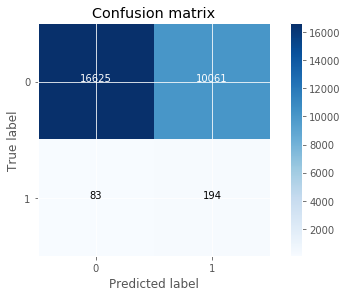

In [31]:
threshold = .5
predicted_proba = clf.decision_function(X_test)
predicted = (predicted_proba >= threshold).astype('int')

y_pred = clf.predict(X_test)
cnf_matrix = confusion_matrix(y_test, y_pred)

fpr, tpr, auc_thresholds = roc_curve(y_test, predicted_proba)
print(auc(fpr, tpr))

print("Recall metric in the testing dataset: {}%".format(100*cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1])))
print("Precision metric in the testing dataset: {}%".format(100*cnf_matrix[0,0]/(cnf_matrix[0,0]+cnf_matrix[1,0])))
print("Accuracy metric in the testing dataset: {}%".format(100*(cnf_matrix[0,0] + cnf_matrix[1,1])/(cnf_matrix[0,0]+cnf_matrix[1,1]+cnf_matrix[0,1]+cnf_matrix[1,0])))
# {tp+tn}/{tp+tn+fp+fn}}
# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix , classes=class_names, title='Confusion matrix')
plt.show()

0.7120325128902484
     pred_neg  pred_pos
neg     22994      3692
pos       167       110


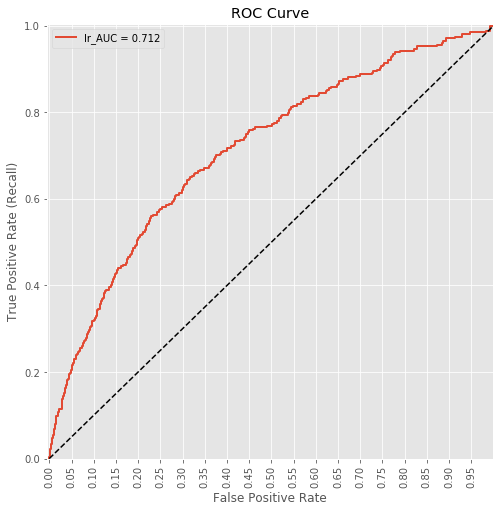

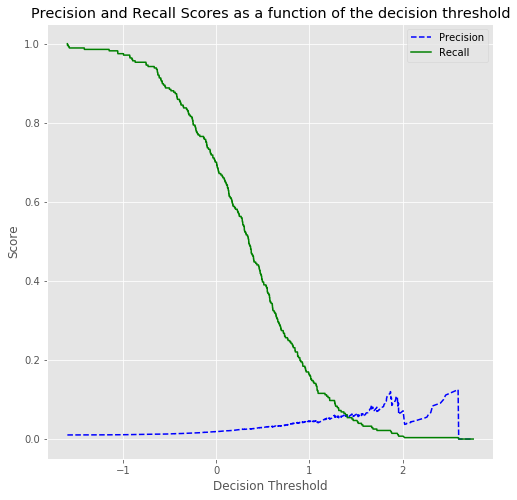

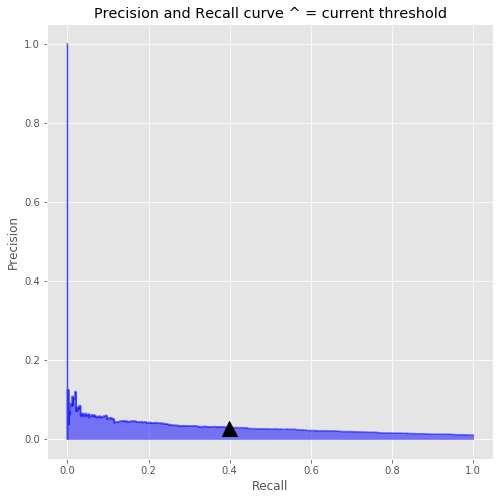

In [32]:
y_scores = clf.decision_function(X_test)

p, r, thresholds = precision_recall_curve(y_test, y_scores)
fpr, tpr, auc_thresholds = roc_curve(y_test, y_scores)
print(auc(fpr, tpr)) # AUC of ROC
plot_roc_curve(fpr, tpr, 'lr')
plot_precision_recall_vs_threshold(p, r, thresholds)
precision_recall_threshold(p, r, thresholds, .5)

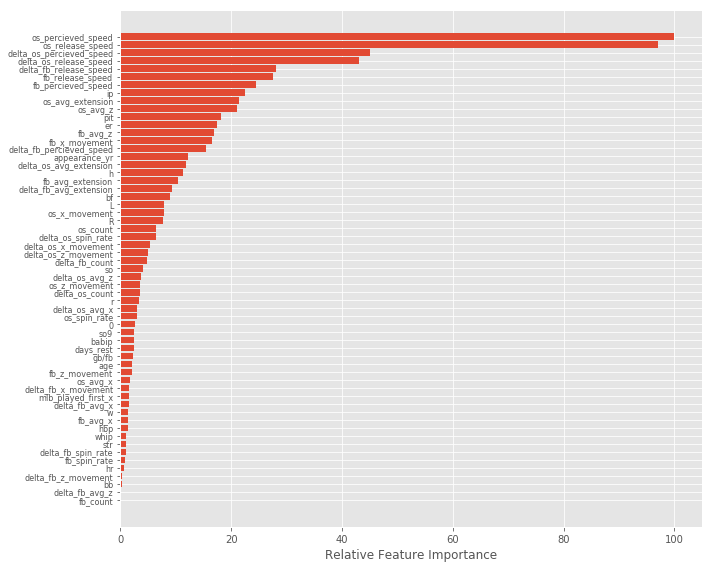

In [33]:
feature_importance = abs(clf.coef_[0])
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

featfig = plt.figure(figsize=(10,8))
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos, feature_importance[sorted_idx], align='center')
featax.set_yticks(pos)
featax.set_yticklabels(np.array(X.columns)[sorted_idx], fontsize=8)
featax.set_xlabel('Relative Feature Importance')

plt.tight_layout()   
plt.show()

In [50]:
# rf = RandomForestClassifier(n_estimators = 300, class_weight='balanced', n_jobs=-1, oob_score=True, max_depth=3, max_features=3)
rf = RandomForestClassifier(n_estimators = 500, class_weight='balanced', n_jobs=-1, oob_score=True, max_depth=7, max_features='sqrt')
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=7, max_features='sqrt',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=-1, oob_score=True, random_state=None,
            verbose=0, warm_start=False)

0.7102646610088552
Recall metric in the testing dataset: 23.826714801444044%
Precision metric in the testing dataset: 99.15572983354673%
Accuracy metric in the testing dataset: 92.15220858213107%


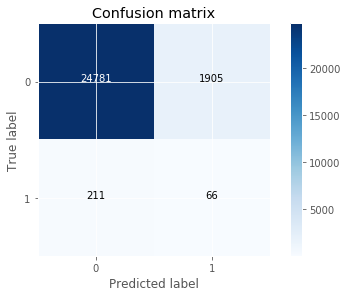

In [59]:
threshold = 0.5
predicted_proba = rf.predict_proba(X_test)[:, 1]
predicted = (predicted_proba >= threshold).astype('int')

y_pred = rf.predict(X_test)
cnf_matrix_rf = confusion_matrix(y_test, predicted)

fpr, tpr, auc_thresholds = roc_curve(y_test, predicted_proba)
print(auc(fpr, tpr))

print("Recall metric in the testing dataset: {}%".format(100*cnf_matrix_rf[1,1]/(cnf_matrix_rf[1,0]+cnf_matrix_rf[1,1])))
print("Precision metric in the testing dataset: {}%".format(100*cnf_matrix_rf[0,0]/(cnf_matrix_rf[0,0]+cnf_matrix_rf[1,0])))
print("Accuracy metric in the testing dataset: {}%".format(100*(cnf_matrix_rf[0,0] + cnf_matrix_rf[1,1])/(cnf_matrix_rf[0,0]+cnf_matrix_rf[1,1]+cnf_matrix_rf[0,1]+cnf_matrix_rf[1,0])))
# {tp+tn}/{tp+tn+fp+fn}}
# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix_rf , classes=class_names, title='Confusion matrix')
plt.show()

0.7102646610088552
     pred_neg  pred_pos
neg     24781      1905
pos       211        66


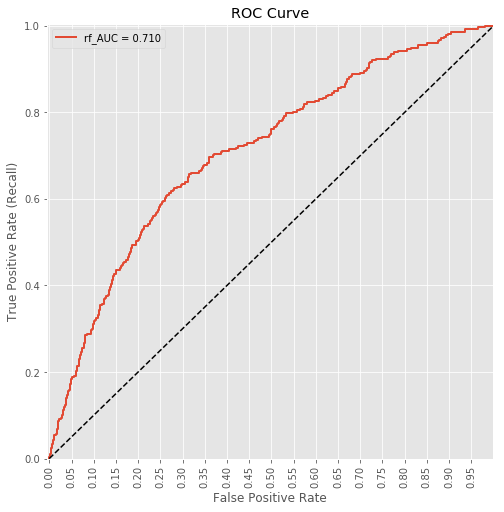

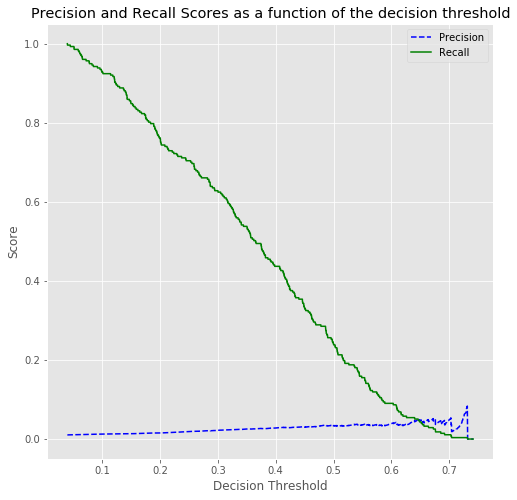

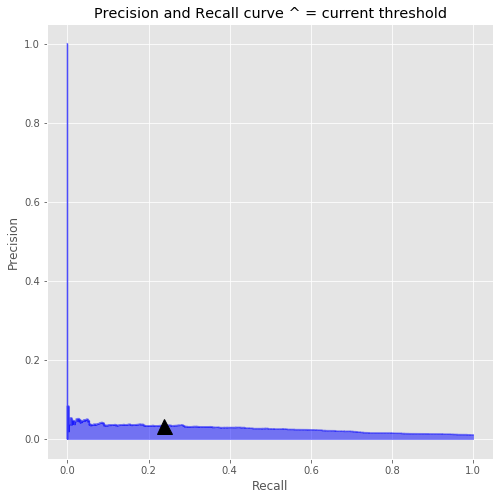

In [60]:
y_scores = rf.predict_proba(X_test)[:, 1]

p, r, thresholds = precision_recall_curve(y_test, y_scores)
fpr, tpr, auc_thresholds = roc_curve(y_test, y_scores)
print(auc(fpr, tpr)) # AUC of ROC
plot_roc_curve(fpr, tpr, 'rf')
plot_precision_recall_vs_threshold(p, r, thresholds)
precision_recall_threshold(p, r, thresholds, .5)

In [53]:
threshold = 0.5

predicted_proba = rf.predict_proba(X_test)
predicted = (predicted_proba [:,1] >= threshold).astype('int')

accuracy = accuracy_score(y_test, predicted)
accuracy

0.9215220858213107

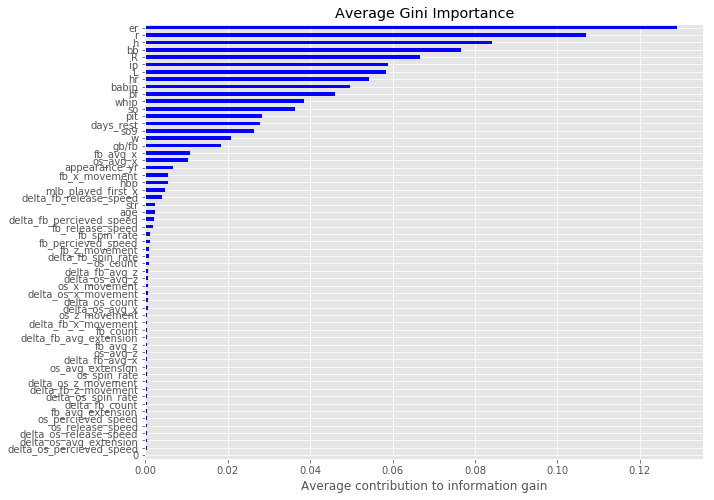

In [54]:
feat_scores = pd.Series(rf.feature_importances_,
                           index=X.columns)
feat_scores = feat_scores.sort_values()
ax = feat_scores.plot(kind='barh', 
                      figsize=(10,8),
                      color='b')
ax.set_title('Average Gini Importance')
ax.set_xlabel('Average contribution to information gain');